In [16]:
import os
import scipy.io

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Configuration parameters
num_channels = 256

##### Load file

In [3]:
filepath = r"F:\RiceStudy\speechBCI\data\tuningTasks"
filename = "t12.2022.04.26_phonemes.mat"
matfile_path = os.path.join(filepath, filename)

tuning_data = scipy.io.loadmat(matfile_path)

##### Generate "phoneme - neural activty" chart

In [4]:
# Extract neural activity and phonemes records
## Phonemes are recorded in tuning_data['trailCues']

## extract indexes in records

audio_start = np.array(tuning_data['goTrialEpochs'][:, 0])
audio_end = np.array(tuning_data['goTrialEpochs'][:, 1])

In [33]:
## extract neural activity

phonemes_chart = ['B','CH','NOTHING','D','F','G','HH','JH','K','L','ER','M','N','NG','P','R','S','SH','DH','T','TH', 'V','W',\
    'Y','Z','ZH','OY','EH','EY','UH','IY','OW','UW','IH','AA','AW','AY','AH','AO','AE']

neu2pho_spikepow_chart = np.zeros((len(phonemes_chart), num_channels))
neu2pho_tx_chart = np.zeros((len(phonemes_chart), num_channels))

pho_cuenum = np.zeros(len(phonemes_chart))

for i in range(len(audio_start)):
    sta_p = audio_start[i]
    end_p = audio_end[i]

    spike_pow_sample = np.array(tuning_data['spikePow'][sta_p : end_p, :])
    tx_sample = np.array(tuning_data['tx1'][sta_p : end_p, :])

    spike_pow_mean = np.mean(spike_pow_sample, axis = 0)
    tx_mean = np.mean(tx_sample, axis = 0)

    pho = tuning_data['trialCues'][i] - 1
    neu2pho_spikepow_chart[pho] += spike_pow_mean
    neu2pho_tx_chart[pho] += tx_mean
    pho_cuenum[pho] += 1

for i in range(len(phonemes_chart)):
    neu2pho_spikepow_chart[i] /= pho_cuenum[i]
    neu2pho_tx_chart[i] /= pho_cuenum[i]

baseline_sp = np.mean(neu2pho_spikepow_chart, axis = 0)
baseline_tx = np.mean(neu2pho_tx_chart, axis = 0)
for i in range(len(phonemes_chart)):
    neu2pho_spikepow_chart[i] -= baseline_sp
    neu2pho_tx_chart[i] -= baseline_tx



##### Representational similarity

In [21]:
# def of cross product calculation
def cross_product(x, y):
    if len(x) != len(y):
        return 0
    
    t = 0
    for i in range(len(x)):
        t += x[i] * y[i]

    return t


# def of representation similarity calculation
def repre_similarity(x, y):
    if cross_product(x, x) == 0 or cross_product(y, y) == 0:
        return 0
    if len(x) != len(y):
        return 0
    
    t = 0
    return cross_product(x, y) / np.sqrt(cross_product(x, x)) / np.sqrt(cross_product(y, y))

In [35]:
# Plot representational similarity
map_similarity = np.zeros((len(phonemes_chart), len(phonemes_chart)))

consonant_clusteredchart = ['P', 'B', 'M', 'F', 'V', 'TH', 'DH', 'T', 'D', 'N', 'S', 'Z', 'CH', 'JH', 'SH', 'ZH', 'NG', 'K', 'G', 'Y', 'L', 'R', 'W']
vowel_clusteredchart = ['OY', 'OW', 'AO', 'AA', 'AW', 'AY', 'AE', 'EH', 'EY', 'IY', 'IH', 'AH', 'UW', 'ER', 'UH']

phoneme_clusteredchart = np.append(consonant_clusteredchart[:], vowel_clusteredchart[:])

## generate shuffle map for the arrays according to phoneme clustering
shuffle_map = [0] * len(phoneme_clusteredchart)
for i in range(len(shuffle_map)):
    shuffleindex = phonemes_chart.index(phoneme_clusteredchart[i])
    shuffle_map[i] = int(shuffleindex)

In [36]:
## calculate similarity
similarity_sp = np.zeros((len(shuffle_map), len(shuffle_map)))
similarity_tx = np.zeros((len(shuffle_map), len(shuffle_map)))

for i in range(len(shuffle_map)):
    for j in range(i, len(shuffle_map)):
        similarity_sp[i, j] = repre_similarity(neu2pho_spikepow_chart[i, :], neu2pho_spikepow_chart[j, :])
        similarity_tx[i, j] = repre_similarity(neu2pho_tx_chart[i, :], neu2pho_tx_chart[j, :])
        similarity_sp[j, i] = similarity_sp[i, j]
        similarity_tx[j, i] = similarity_tx[i, j]

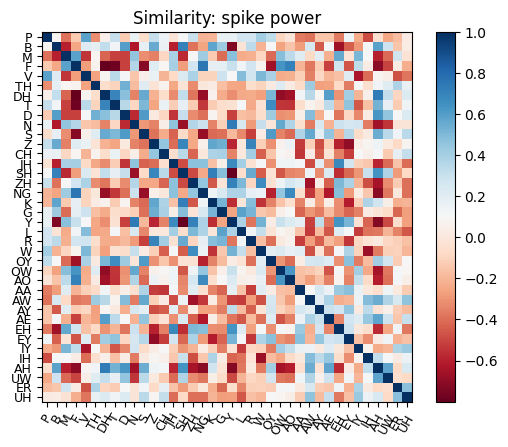

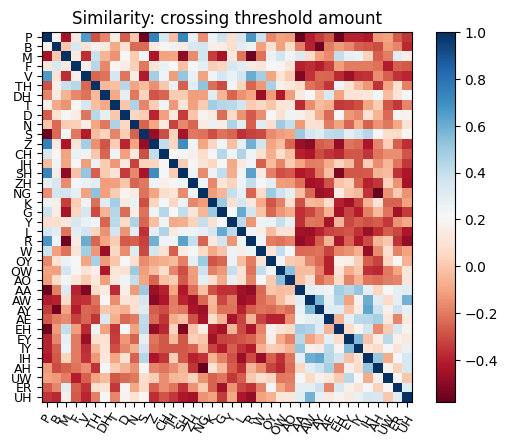

<Figure size 640x480 with 0 Axes>

In [38]:
## plot similarity
plt.imshow(similarity_sp, cmap='RdBu')
plt.title("Similarity: spike power")
plt.colorbar()
plt.xticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9, rotation=60)
plt.yticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9)
plt.show()

plt.clf()

plt.imshow(similarity_tx, cmap='RdBu')
plt.title("Similarity: crossing threshold amount")
plt.xticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9, rotation=60)
plt.yticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9)
plt.colorbar()
plt.show()

plt.clf()

##### Clustering 2022.04.26

##### Debug Zone

In [34]:
print(np.shape(neu2pho_spikepow_chart))
print(len(shuffle_map))

print(similarity_sp)
print(similarity_tx)

print(neu2pho_spikepow_chart)
print(neu2pho_tx_chart)

(40, 256)
38
[[1.         0.99014505 0.96636807 ... 0.98782109 0.99128559 0.9868842 ]
 [0.99014505 1.         0.9543922  ... 0.99264592 0.99037116 0.98561967]
 [0.96636807 0.9543922  1.         ... 0.96408187 0.97873577 0.96630099]
 ...
 [0.98782109 0.99264592 0.96408187 ... 1.         0.99290063 0.98592041]
 [0.99128559 0.99037116 0.97873577 ... 0.99290063 1.         0.99312456]
 [0.9868842  0.98561967 0.96630099 ... 0.98592041 0.99312456 1.        ]]
[[1.         0.98623724 0.95312893 ... 0.98155016 0.98103935 0.97920965]
 [0.98623724 1.         0.97387096 ... 0.98768429 0.98912081 0.9867192 ]
 [0.95312893 0.97387096 1.         ... 0.96805549 0.97796576 0.97180029]
 ...
 [0.98155016 0.98768429 0.96805549 ... 1.         0.99234002 0.99031568]
 [0.98103935 0.98912081 0.97796576 ... 0.99234002 1.         0.99268407]
 [0.97920965 0.9867192  0.97180029 ... 0.99031568 0.99268407 1.        ]]
[[ 9.00214594e+00  5.17661543e+01 -4.43895485e+01 ... -1.63214619e+01
   1.50410736e+01  5.37764293